# Word Embeddings

In previous tutorial we talked about word vectors. In this part we will talk about word embeddings and how we can create them from scratch.  

## Embeddings and Pytorch

Embeddings created and trained with usage of one hot vectors and linear layers for example; 

In [1]:
import torch
import torch.nn as nn
print(torch.__version__)

1.10.0+cu111


In [2]:
input = torch.arange(0, 3)
one_hot =nn.functional.one_hot(input,num_classes = 3).type(torch.FloatTensor)
linear_layer=nn.Linear(in_features=3,out_features=2,bias=False)
output_layer =linear_layer(one_hot)
print('input: ', input)
print('one hot :\n ', one_hot)
print('linear layer: \n', linear_layer.weight)
print('output:\n ', output_layer)

input:  tensor([0, 1, 2])
one hot :
  tensor([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]])
linear layer: 
 Parameter containing:
tensor([[ 0.5722, -0.0285,  0.1677],
        [ 0.4542,  0.2498,  0.4412]], requires_grad=True)
output:
  tensor([[ 0.5722,  0.4542],
        [-0.0285,  0.2498],
        [ 0.1677,  0.4412]], grad_fn=<MmBackward0>)


As you can see from the example above our outputs are similar to weights of the linear layer. First column is containing embedding of `word 0`, second column containing embeddings of the `word 1` so on.  Training these weights will give us the trained word embeddings.

For example, in a data set containing  1 million different word tokens and embedding size of 300 we will obtain a layer with 300 million parameters. To speed up the process PyTorch provides `nn.Embedding` module which we mentioned at one of our previous tutorials. [Pytorch documentation]( https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html) page about this module  say that “A simple lookup table that stores embeddings of a fixed dictionary and size.”. Lets look at the following example;

In [ ]:
input = torch.arange(0, 3)
embedding_layer = nn.Embedding(num_embeddings=3,embedding_dim=2)
output = embedding_layer(input)
print('input: ', input)
print('embedding layer: \n', embedding_layer.weight)
print('output:\n ', output)

input:  tensor([0, 1, 2])
embedding layer: 
 Parameter containing:
tensor([[-1.1833,  1.5897],
        [ 2.2768,  0.3499],
        [-1.3668, -0.1086]], requires_grad=True)
output:
  tensor([[-1.1833,  1.5897],
        [ 2.2768,  0.3499],
        [-1.3668, -0.1086]], grad_fn=<EmbeddingBackward>)


Embedding layer provides improved optimization, additional parameters like padding loading pretrained embedding etc.  For more information about `nn.Embedding’, I suggest you check [Pytorch documentation](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html) page.

## CBOW



First word embedding model we will  implement in this tutorial is: Continuous Bag of Words (CBOW). 

In this example, we will follow one of the tutorials provided by PyTorch [tutorial page]( https://pytorch.org/tutorials/index.html).  

Let's start with importing necessary libraries(again).


In [3]:
import torch
import torch.nn as nn
print(torch.__version__)

1.10.0+cu111


### Data Preparation

In [4]:
raw_text = """We are about to study the idea of a computational process.
Computational processes are abstract beings that inhabit computers.
As they evolve, processes manipulate other abstract things called data.
The evolution of a process is directed by a pattern of rules
called a program. People create programs to direct processes. In effect,
we conjure the spirits of the computer with our spells.""".split()

We will use the corpus shown above which is given at previously mentioned tutorial.  Please note that we are skipping the tokenizing for this example for simplicity.    
As you know CBOW uses context words (words surrounding  the target word) to predict the center (or target) word.    

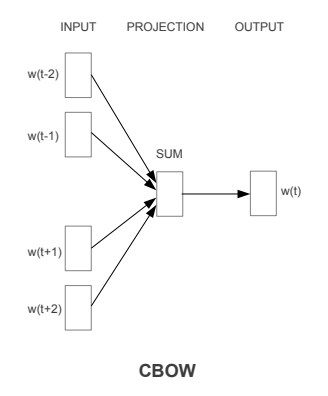

As a first step let’s create our context and target sets.

In [5]:
CONTEXT_SIZE = 2  # 2 words to the left, 2 to the right

data = []
for i in range(CONTEXT_SIZE, len(raw_text) - CONTEXT_SIZE):
    context = raw_text[(i - CONTEXT_SIZE):(i)]+ raw_text[(i+1): (i+1 + CONTEXT_SIZE)]      
    target = raw_text[i]
    data.append((context, target))

print(data[:10])

[(['We', 'are', 'to', 'study'], 'about'), (['are', 'about', 'study', 'the'], 'to'), (['about', 'to', 'the', 'idea'], 'study'), (['to', 'study', 'idea', 'of'], 'the'), (['study', 'the', 'of', 'a'], 'idea'), (['the', 'idea', 'a', 'computational'], 'of'), (['idea', 'of', 'computational', 'process.'], 'a'), (['of', 'a', 'process.', 'Computational'], 'computational'), (['a', 'computational', 'Computational', 'processes'], 'process.'), (['computational', 'process.', 'processes', 'are'], 'Computational')]


In [6]:
vocab = set(raw_text)
vocab_size = len(vocab)
print(vocab_size)

49


Now that we created our dataset, our next step is converting words to numbers.  
Luckily due to our small corpus we only have 49 different words. Working on bigger datasets like Wikipedia or Tweeter generally means working on vocabularies which contain thousands of words.

In [7]:
word_to_ix = {word: i for i, word in enumerate(vocab)}  # a dictionary that is similar to torchtext's stoi function
ix_to_word = {ix:word for ix, word in enumerate(vocab)} # a dictionary that is similar to torchtext's itos function

print('word to ix converts word to numbers: word_to_ix["We"] ->', word_to_ix["We"])
print("ix to word converts word to numbers: ix_to_word[28] ->", ix_to_word[28])

word to ix converts word to numbers: word_to_ix["We"] -> 19
ix to word converts word to numbers: ix_to_word[28] -> they


In [8]:
def make_context_vector(context, word_to_ix):  # function to convert our word array to  torch tensor
    idxs = [word_to_ix[w] for w in context]
    return torch.tensor(idxs, dtype=torch.long)

print("Make context vector function convert our data set to tensors:\n", data[0][0],"->", make_context_vector(data[0][0], word_to_ix))
print("\nFor target we can still use: \nword_to_ix[data[0][1]]->",word_to_ix[data[0][1]])

Make context vector function convert our data set to tensors:
 ['We', 'are', 'to', 'study'] -> tensor([19, 31, 25,  1])

For target we can still use: 
word_to_ix[data[0][1]]-> 40


### Network

Now that our data is ready We will implement  our network while utilizing `nn.Embedding` module in our network.

In [9]:
class CBOWnetwork(nn.Module):

    def __init__(self, vocab_size, embedding_dim,hidden_dim):  
        super(CBOWnetwork, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)  
        self.linear1 = nn.Linear(embedding_dim, hidden_dim)   
        self.relu1 = nn.ReLU()        
        self.linear2 = nn.Linear(hidden_dim, vocab_size)  # We need output size equal to vocab_size
        self.softmax = nn.LogSoftmax(dim = -1)
        

    def forward(self, inputs):
        embeds = sum(self.embeddings(inputs)).view(1,-1)   # as CBOW model says we will sum our embeddings .view(1,-1) prepares  our output for next layer.
        x = self.linear1(embeds)
        x = self.relu1(x)

        x = self.linear2(x)
        x = self.softmax(x)   
        return x
        
    def get_word_embedding(self, word):
        word = torch.tensor([word_to_ix[word]])
        return self.embeddings(word).view(1,-1)

The CBOW Network above contains 2 linear layers with RELU activation between and LogSoftMax layer at the end. This SoftMax function return probability distribution over our vocabulary. 

Lets initiate our network. 


In [10]:
EMBEDDING_DIM = 5  # For this example, Let’s choose 5 as our embedding dimension. You are welcome to try with different dimension sizes.
loss_function = nn.NLLLoss()  # The negative log likelihood loss is useful when we have N number of clases
HIDDEN_DIM = 10

model = CBOWnetwork(len(vocab), EMBEDDING_DIM,HIDDEN_DIM)   #If you want to work on the GPU you can add the `.cuda()` to end. Because it is a small network, we will work on CPU.

optimizer = torch.optim.SGD(model.parameters(), lr=0.001) 

Last step is as always training our network/embeddings. 

In [11]:
losses = []   # for keeping the losses
EPOCHS = 800  # because of our small dataset we need to increase our epoch count
j =0
for epoch in range(EPOCHS):    
    total_loss = 0
    i=0 
    j +=1
    for context, target in data:     #lets get our context and target
        
        # Remove the gradients for next iteration
        model.zero_grad()   
       
        # Convert the corpus in to integers.
        context_idxs = make_context_vector(context,word_to_ix)  
        #print("Context id: ",context_idxs)
      
        # forward pass
        log_probs = model(context_idxs)

        # calculate the Loss
        loss = loss_function(log_probs, torch.tensor([word_to_ix[target]], dtype=torch.long))
        #print(loss)

        # backward Pass
        loss.backward()

        # Gradient decent using optimizer 
        optimizer.step()
        i += 1
        # 
        total_loss += loss.item()
    if j%50 ==0:
      print("epoch", j ,"avarage epoch loss:", total_loss/i)
    losses.append(total_loss)


epoch 50 avarage epoch loss: 3.594885797336184
epoch 100 avarage epoch loss: 3.275382342009709
epoch 150 avarage epoch loss: 2.9209671390467675
epoch 200 avarage epoch loss: 2.5163234965554597
epoch 250 avarage epoch loss: 2.089176289480308
epoch 300 avarage epoch loss: 1.6841363100142315
epoch 350 avarage epoch loss: 1.3263905284733608
epoch 400 avarage epoch loss: 1.0349088216136242
epoch 450 avarage epoch loss: 0.8064203340688656
epoch 500 avarage epoch loss: 0.6314263918019575
epoch 550 avarage epoch loss: 0.49891935777047586
epoch 600 avarage epoch loss: 0.3983761128680459
epoch 650 avarage epoch loss: 0.32068022918598404
epoch 700 avarage epoch loss: 0.26064445868391417
epoch 750 avarage epoch loss: 0.21299632034938912
epoch 800 avarage epoch loss: 0.17566708645558562


### Output

Now that we trained our network. Let's see an Prediction example;

In [12]:
context = ['Computational','processes', 'abstract','beings']
context_vector = make_context_vector(context, word_to_ix)
result = model(context_vector)

print(f'Prediction: {ix_to_word[torch.argmax(result[0]).item()]}')

Prediction: are


In [13]:
context = ['We','study', 'abstract','things']  #let's try phrase that does not exist in our data
context_vector = make_context_vector(context, word_to_ix)
result = model(context_vector)

print(f'Prediction: {ix_to_word[torch.argmax(result[0]).item()]}')

Prediction: to



`get_word_embeddings` function of our network returns trained embeddings of the given word.




In [14]:
model.get_word_embedding('are')

tensor([[ 0.6575,  1.6257,  0.9849, -0.2222,  1.3824]],
       grad_fn=<ViewBackward0>)

## Another CBOW example

This time We will change our input to observe the effectiveness of the embeddings.

In [15]:
raw_text = """We are about to study the idea of a computational process.
              We are about to learn the idea of a computational process.
              We are about to study the way of a computational process.
              We are about to learn the way of a computational process.""".split()

As you can see our new text 4 sentences that replaces `study` with `learn` and `idea` with `way`. If  we look at the  CBOW model after training weights of these words will be similar due to positions of the words. Lets create our network and see the embeddings of these words while training.

In [16]:
CONTEXT_SIZE = 2  # 2 words to the left, 2 to the right
data = []
for i in range(CONTEXT_SIZE, len(raw_text) - CONTEXT_SIZE):
    context = raw_text[(i - CONTEXT_SIZE):(i)]+ raw_text[(i+1): (i+1 + CONTEXT_SIZE)]      
    target = raw_text[i]
    data.append((context, target))

In [17]:
vocab = set(raw_text)
vocab_size = len(vocab)
word_to_ix = {word: i for i, word in enumerate(vocab)}
ix_to_word = {ix:word for ix, word in enumerate(vocab)}

In [18]:
class CBOWnetwork(nn.Module):
    def __init__(self, vocab_size, embedding_dim):  
        super(CBOWnetwork, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(embedding_dim, vocab_size)   
        self.softmax = nn.LogSoftmax(dim = -1)
    def forward(self, inputs):
        embeds = torch.sum(self.embeddings(inputs),0).view(1,-1)
        x = self.linear1(embeds)
        x = self.softmax(x)
        return x
    def get_word_embedding(self, word):
        word = torch.tensor([word_to_ix[word]])
        return self.embeddings(word).view(1,-1)

In [19]:
EMBEDDING_DIM = 1  
loss_function = nn.NLLLoss()  # The negative log likelihood loss is useful when we have N number of clases
model = CBOWnetwork(len(vocab), EMBEDDING_DIM)   #If you want to work on the GPU you can add the `.cuda()` to end. Because it is a small network, we will work on CPU.
optimizer = torch.optim.SGD(model.parameters(), lr=0.001) 

In [20]:
losses = []   # for keeping the losses
EPOCHS = 1601  # lower learning rate and small data

j=0
for epoch in range(EPOCHS):    
    total_loss = 0
    i=0 
    for context, target in data:     #lets get our context and target
        
        # Remove the gradients for next iteration
        model.zero_grad()   
       
        # Convert the corpus in to integers.
        context_idxs = make_context_vector(context,word_to_ix)  
        #print("Context id: ",context_idxs)
      
        # forward pass
        log_probs = model(context_idxs)

        # calculate the Loss
        loss = loss_function(log_probs, torch.tensor([word_to_ix[target]], dtype=torch.long))
        #print(loss)

        # backward Pass
        loss.backward()

        # Gradient decent using optimizer 
        optimizer.step()

        # 
        total_loss += loss.item()
        i +=1
    if j%100 ==0:
      print(f'epoch  {j}  avarage loss  {(total_loss/i):0}')
      model.eval()
      with torch.no_grad():
        print("study:", model.get_word_embedding('study').item(),"learn:", model.get_word_embedding('learn').item())
        print("idea:", model.get_word_embedding('idea').item(),"way:", model.get_word_embedding('way').item(), '\n')
      model.train()
    losses.append(total_loss)
    j += 1

epoch  0  avarage loss  3.2231380462646486
study: -0.4238468110561371 learn: -1.1361768245697021
idea: 0.4530589282512665 way: -0.7570272088050842 

epoch  100  avarage loss  2.3028725907206535
study: -0.4351454973220825 learn: -1.0141347646713257
idea: 0.4946494996547699 way: -0.5007241368293762 

epoch  200  avarage loss  1.9740804195404054
study: -0.5928704738616943 learn: -1.0786617994308472
idea: 0.49226200580596924 way: -0.32494211196899414 

epoch  300  avarage loss  1.8162859693169593
study: -0.7324966788291931 learn: -1.1137698888778687
idea: 0.47320982813835144 way: -0.16202011704444885 

epoch  400  avarage loss  1.7334830567240715
study: -0.8212524056434631 learn: -1.1127862930297852
idea: 0.4451417326927185 way: -0.030553463846445084 

epoch  500  avarage loss  1.6719258174300193
study: -0.8844743967056274 learn: -1.1053204536437988
idea: 0.4183821380138397 way: 0.07021601498126984 

epoch  600  avarage loss  1.62040758356452
study: -0.9337683916091919 learn: -1.0992170572

As you can see with after random initilaztion of the embedding layer, weights of these words start to converge with with each epoch of  training. 

##GLOVE

Next word embedding model we will  implement in this tutorial is: Global Vectors for Word Representation (GloVe).  [GloVe project page]( https://nlp.stanford.edu/projects/glove/) intoduce Glove as follows “GloVe is an unsupervised learning algorithm for obtaining vector representations for words. Training is performed on aggregated global word-word co-occurrence statistics from a corpus, and the resulting representations showcase interesting linear substructures of the word vector space.”

In previous tutorials we used pretrained GloVe word vectors to train our network or see similarities of the words. In this part we will create our own GloVe  embeddings while following process explained on its [paper]( https://nlp.stanford.edu/pubs/glove.pdf)

Let's start with importing necessary libraries(again).


In [21]:
from collections import Counter, defaultdict
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.manifold import TSNE

In [22]:
raw_text = """We are about to study the idea of a computational process.
Computational processes are abstract beings that inhabit computers.
As they evolve, processes manipulate other abstract things called data.
The evolution of a process is directed by a pattern of rules
called a program. People create programs to direct processes. In effect,
we conjure the spirits of the computer with our spells.""".split()

In [23]:
vocab = set(raw_text)
vocab_size = len(vocab)
print(vocab_size)

49


In [24]:
word_to_ix = {word: i for i, word in enumerate(vocab)}
ix_to_word = {ix:word for ix, word in enumerate(vocab)}

print('word to ix converts word to numbers: word_to_ix["We"] ->', word_to_ix["We"])
print("ix to word converts word to numbers: ix_to_word[12] ->", ix_to_word[12])

word to ix converts word to numbers: word_to_ix["We"] -> 19
ix to word converts word to numbers: ix_to_word[12] -> inhabit


Now that we imported our libraries and created our text (I suggest you to try this model with bigger datasets.) , our next step is creating your `cooccurrence matrix`. As you know Glove model leverages this matrix to find semantic relationships between words.  

If you have trouble understanding Glove, I suggest you to check  [this paper]( https://towardsdatascience.com/light-on-math-ml-intuitive-guide-to-understanding-glove-embeddings-b13b4f19c010) which explains Glove model step by step.


In [25]:
ix_tokens = [word_to_ix[w] for w in raw_text]
window_size = 2


cooc_mat = defaultdict(Counter)   
for i, w in enumerate(ix_tokens):  #returns location(i) and word number(w)
    start_i = max(i - window_size, 0)
    end_i = min(i + window_size + 1, len(ix_tokens))
    for j in range(start_i, end_i):
        if i != j:
          c = ix_tokens[j]
          cooc_mat[w][c] +=  1 / abs(j-i) 

i_idx = list()
j_idx = list()
xij = list()

#Create indexes and x values tensors
for w, cnt in cooc_mat.items():  # returns first word
    for c, v in cnt.items():  #returns second word and number of times
        i_idx.append(w)
        j_idx.append(c)
        xij.append(v)

i_idx = torch.LongTensor(i_idx).cuda()
j_idx = torch.LongTensor(j_idx).cuda()
xij = torch.FloatTensor(xij).cuda()

In [26]:
print("word ",ix_to_word[i_idx[0].item()],"and word ",ix_to_word[j_idx[0].item()],"co occurance is: ",xij[0].item())

word  We and word  are co occurance is:  1.0


As next step lets create batches to train in our network.

In [27]:
def get_batches(batch_size):
    #Generate random idx
    rand_ids = torch.LongTensor(np.random.choice(len(xij), len(xij), replace=False))
    for p in range(0, len(rand_ids), batch_size):
        batch_ids = rand_ids[p:p+batch_size]
        yield xij[batch_ids], i_idx[batch_ids], j_idx[batch_ids]

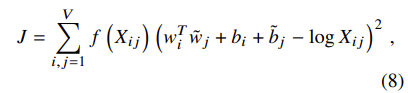

Above formula taken from Glove paper. We need to train weights so let’s impellent them in our network

Wi and wj are embedding weights of the center word and context word and bi and bj are biases of them. Xij represents the co-occurrence of i'th center word and j'th context word.

In [28]:
EMBED_DIM = 10 #10 is a small dimension but we have 49 different words we are looking to reduce the dimensions
class GloveModel(nn.Module):
    def __init__(self, num_embeddings, embedding_dim):
        super(GloveModel, self).__init__()
        self.wi = nn.Embedding(num_embeddings, embedding_dim)
        self.wj = nn.Embedding(num_embeddings, embedding_dim)
        self.bi = nn.Embedding(num_embeddings, 1)
        self.bj = nn.Embedding(num_embeddings, 1)

        self.wi.weight.data.uniform_(-1, 1)
        self.wj.weight.data.uniform_(-1, 1)
        self.bi.weight.data.zero_()
        self.bj.weight.data.zero_()

    def forward(self, i_indices, j_indices):
        w_i = self.wi(i_indices)
        w_j = self.wj(j_indices)
        b_i = self.bi(i_indices).squeeze()
        b_j = self.bj(j_indices).squeeze()

        x = torch.sum(w_i * w_j, dim=1) + b_i + b_j

        return x
glove = GloveModel(vocab_size, EMBED_DIM)
glove.cuda()

GloveModel(
  (wi): Embedding(49, 10)
  (wj): Embedding(49, 10)
  (bi): Embedding(49, 1)
  (bj): Embedding(49, 1)
)

Next step is defining F(Xij) function which is given below

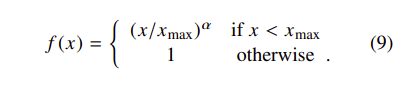

In [29]:
def weight_func(x, x_max, alpha):
        wx = (x/x_max)**alpha
        wx = torch.min(wx, torch.ones_like(wx))
        return wx.cuda()

In Glove paper uses AdaGrad optimizer and Weighted mean least square error loss function lets implement them

In [30]:
 def wmse_loss(weights, inputs, targets):
        loss = weights * F.mse_loss(inputs, targets, reduction='none')
        return torch.mean(loss).cuda()

In [31]:
optimizer = optim.Adagrad(glove.parameters(), lr=0.05)

Next step is the training.  In this part only difference is we need to calculate weights before calculating the loss function.  We took alpha and X_max values same as the paper. On the other hand number of epochs and batch size is kept relatively low to compensate our small corpus.

In [32]:
N_EPOCHS = 10 #100
BATCH_SIZE = 2  
X_MAX = 100
ALPHA = 0.75
n_batches = int(len(xij) / BATCH_SIZE)
loss_values = list()

for e in range(1, N_EPOCHS+1):
    batch_i = 0

    for x_ij_, i_idx_, j_idx_ in get_batches(BATCH_SIZE):

        batch_i += 1

        optimizer.zero_grad()

        outputs = glove(i_idx_, j_idx_)
        weights_x = weight_func(x_ij_, X_MAX, ALPHA)
        loss = wmse_loss(weights_x, outputs, torch.log(x_ij_))

        loss.backward()

        optimizer.step()

        loss_values.append(loss.item())

    print("Epoch: {}/{} \t  \t Loss: {}".format(e, N_EPOCHS, np.mean(loss_values[-20:])))  

    print("Saving model...")
    torch.save(glove.state_dict(), "glove_dum.pt")

Epoch: 1/10 	  	 Loss: 0.04521858748048544
Saving model...
Epoch: 2/10 	  	 Loss: 0.013378384415409528
Saving model...
Epoch: 3/10 	  	 Loss: 0.010578918547253124
Saving model...
Epoch: 4/10 	  	 Loss: 0.0069400242031406375
Saving model...
Epoch: 5/10 	  	 Loss: 0.007909655355615542
Saving model...
Epoch: 6/10 	  	 Loss: 0.007171882368857041
Saving model...
Epoch: 7/10 	  	 Loss: 0.005429342573916074
Saving model...
Epoch: 8/10 	  	 Loss: 0.0024237605117377824
Saving model...
Epoch: 9/10 	  	 Loss: 0.0026310110688427812
Saving model...
Epoch: 10/10 	  	 Loss: 0.003550004618591629
Saving model...


Lastly as the paper suggested we will take average of the two weights and show the visualization of our trained embeddings.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:827: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning,


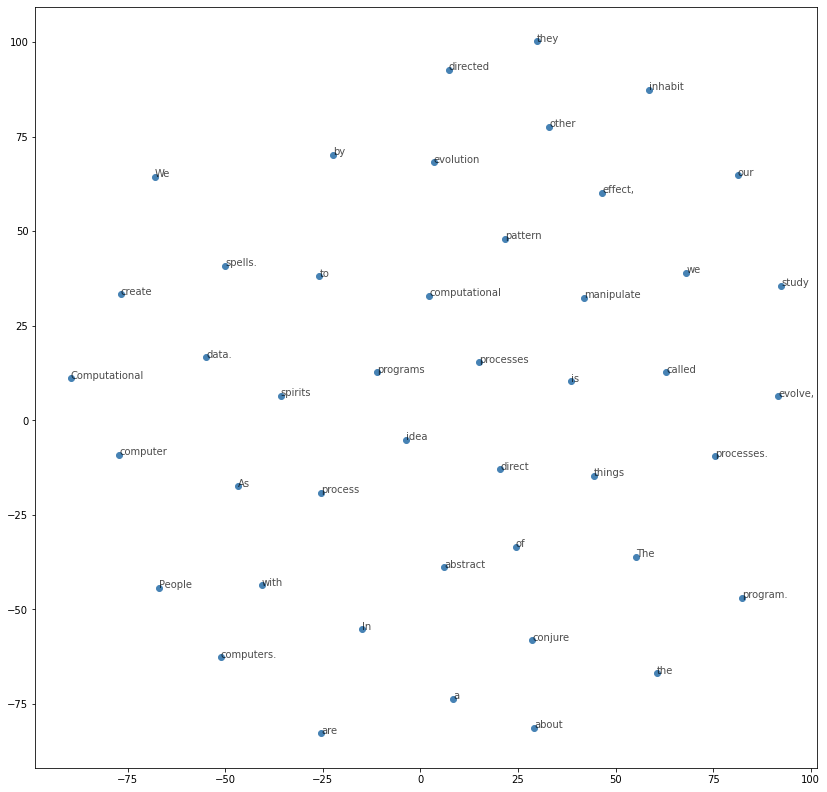

In [33]:
emb_i = glove.wi.weight.cpu().data.numpy()
emb_j = glove.wj.weight.cpu().data.numpy()
emb = emb_i + emb_j
top_k = 45 
tsne = TSNE(metric='cosine', random_state=123)
embed_tsne = tsne.fit_transform(emb[:top_k, :])
fig, ax = plt.subplots(figsize=(14, 14))
for idx in range(top_k):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(ix_to_word[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)

##Fast Text


Last word embedding  we will implement in this tutorial is `Fasttext` which is developed by `Facebook Research`.  [Fast text](https://fasttext.cc/)  divides each word to n-grams than it creates embeddings using other methods like CBOW or Skipgram.

Let's start with importing necessary libraries(again).

In [34]:
raw_text = """We are about to study the idea of a computational process.
Computational processes are abstract beings that inhabit computers.
As they evolve, processes manipulate other abstract things called data.
The evolution of a process is directed by a pattern of rules
called a program. People create programs to direct processes. In effect,
we conjure the spirits of the computer with our spells.""".lower().split()

In this tutorial we will create Fasttext model using CBOW example. Please note that we are skipping tokenizing steps again.

In [35]:
CONTEXT_SIZE = 2  # 2 words to the left, 2 to the right

data = []
for i in range(CONTEXT_SIZE, len(raw_text) - CONTEXT_SIZE):
    context = raw_text[(i - CONTEXT_SIZE):(i)]+ raw_text[(i+1): (i+1 + CONTEXT_SIZE)]      
    target = raw_text[i]
    data.append((context, target))

print(data[:10])

[(['we', 'are', 'to', 'study'], 'about'), (['are', 'about', 'study', 'the'], 'to'), (['about', 'to', 'the', 'idea'], 'study'), (['to', 'study', 'idea', 'of'], 'the'), (['study', 'the', 'of', 'a'], 'idea'), (['the', 'idea', 'a', 'computational'], 'of'), (['idea', 'of', 'computational', 'process.'], 'a'), (['of', 'a', 'process.', 'computational'], 'computational'), (['a', 'computational', 'computational', 'processes'], 'process.'), (['computational', 'process.', 'processes', 'are'], 'computational')]


First we need to create character ngrams for this example we will use minimum of 1 and maximum of 2 for simplicity. 

In [36]:
def char_ngram(word,pad_max=None): #for simplicty we will use 2
  out =list()
  out.append(word[0])
  for i in range(len(word)):
    out.append(word[i:i+2]) 
 
  if (pad_max):
    out += [' '] * (pad_max - len(out))
  return out
print(char_ngram('we',5))
print(char_ngram('weird'))

['w', 'we', 'e', ' ', ' ']
['w', 'we', 'ei', 'ir', 'rd', 'd']


Next, we need to create our vocabulary and maximum length of the ngrams. Because our corpus is small we can go over all of the words and create our library. In an actual case we can assume that every ngram combination can present itself. In addition maximum length(if needed) can be set arbitrarily .

In [37]:
max_length = 0 
vocab_char =list()
for i in range(len(raw_text)):
  if (max_length<len(char_ngram(raw_text[i]))):
    max_length = len(char_ngram(raw_text[i]))
    print(raw_text[i])
    print(char_ngram(raw_text[i]))
  vocab_char +=(char_ngram(raw_text[i]))
max_length

we
['w', 'we', 'e']
are
['a', 'ar', 're', 'e']
about
['a', 'ab', 'bo', 'ou', 'ut', 't']
computational
['c', 'co', 'om', 'mp', 'pu', 'ut', 'ta', 'at', 'ti', 'io', 'on', 'na', 'al', 'l']


14

In [38]:
vocab = set(vocab_char)
vocab_size = len(vocab)
print(vocab_size)

130


In [39]:
word_to_ix = {word: i for i, word in enumerate(vocab)}
ix_to_word = {ix:word for ix, word in enumerate(vocab)}

In [40]:
try:
  word_to_ix[" "]
except:
  print("key doesn't exist")

key doesn't exist


Now that we created our library and find our max length but our vocabulary does not contain our selected padding token `space` so we need to add it to our dictionary 

In [41]:
word_to_ix[" "]=130
ix_to_word[130] = " "
vocab.add(" ")
vocab_size +=1

In [42]:
try:
  print(word_to_ix[" "])
except:
  print("key doesn't exist")

130


In [43]:
def make_context_vector(context, word_to_ix):
    idxs = [word_to_ix[j] for j in context]
    return torch.tensor(idxs, dtype=torch.long)

print("Make context vector function convert our data set to tensors:\n", ["w","we","e"],"->", make_context_vector(["w","we","e"], word_to_ix))

Make context vector function convert our data set to tensors:
 ['w', 'we', 'e'] -> tensor([58, 63, 48])


In [44]:
embeddings_test  = nn.Embedding(vocab_size, 8,padding_idx=130)  # It takes vocabulary size and output embedding dimensions
asd = make_context_vector(["w","we","e"," "], word_to_ix)
print(asd)
embeddings_test(torch.tensor(130))

tensor([ 58,  63,  48, 130])


tensor([0., 0., 0., 0., 0., 0., 0., 0.], grad_fn=<EmbeddingBackward0>)

Different then our original CBOW tutorial we will use the padding and outputs of ngrams.  We will achieve this with changing dimensions of  the first fully connected layer and setting `padding_idx` parameter of the embedding layer.

In [45]:
class fasttextnetwork(nn.Module):

    def __init__(self, vocab_size, embedding_dim):  
        super(fasttextnetwork, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim,padding_idx=130)
        self.linear1 = nn.Linear(embedding_dim*4*14, 128)   
        self.relu1 = nn.ReLU()        
        self.linear2 = nn.Linear(128, vocab_size*14)
        self.softmax = nn.LogSoftmax(dim = 1)
        

    def forward(self, words):
        embeds = self.embeddings(words).view(-1)
        x = self.linear1(embeds)
        x = self.relu1(x)
        x = self.linear2(x).view(14,-1)
        x = self.softmax(x)
        return x
    def get_word_emdedding(self, word):
        word = torch.tensor([word_to_ix[word]])
        return self.embeddings(word).view(1,-1)

In [46]:
EMBEDDING_DIM = 20  # For this example, Let’s choose 20 as our embedding dimension. You are welcome to try with different dimension sizes.
loss_function = nn.NLLLoss()  # The negative log likelihood loss is useful when we have N number of clases

model = fasttextnetwork(len(vocab), EMBEDDING_DIM)   #If you want to work on the GPU you can add the `.cuda()` to end. Because it is a small network, we will work on CPU.
print(model)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001) 

fasttextnetwork(
  (embeddings): Embedding(131, 20, padding_idx=130)
  (linear1): Linear(in_features=1120, out_features=128, bias=True)
  (relu1): ReLU()
  (linear2): Linear(in_features=128, out_features=1834, bias=True)
  (softmax): LogSoftmax(dim=1)
)


Following function will create inputs for our network. It will convert  4 strings into `14*4` size tensor while processing them using ngrams.

In [47]:
def create_input(arr,dictionary,pad_size=0):   #take string array and turn it into integers 
  context_idxs_1 = make_context_vector(char_ngram(arr[0],pad_size),word_to_ix) 
  context_idxs_2 = make_context_vector(char_ngram(arr[1],pad_size),word_to_ix)  
  context_idxs_3 = make_context_vector(char_ngram(arr[2],pad_size),word_to_ix)  
  context_idxs_4 = make_context_vector(char_ngram(arr[3],pad_size),word_to_ix)   
  return torch.cat((context_idxs_1 , context_idxs_2 , context_idxs_3 , context_idxs_4),dim=0)

context = ['computational','processes', 'abstract','beings']
print(create_input(context,word_to_ix,14))

tensor([111,  84, 117,  80, 128,  82,  32, 123,  71,  55,  39,   6,  91, 105,
         61,  83,  72,  54,  64, 110,  77,  51, 110,   3, 130, 130, 130, 130,
          9,  62,  53,  29, 126, 102,  68,  27,  92, 130, 130, 130, 130, 130,
         17,  40,  90,  60,  15,  73,   3, 130, 130, 130, 130, 130, 130, 130])


In [48]:
losses = []   # for keeping the losses
EPOCHS = 300   
for epoch in range(EPOCHS):    
    total_loss = 0
    i =0
    for context, target in data:     #lets get our context and target
        
        # Remove the gradients for next iteration
        model.zero_grad()   
       
        # Convert the corpus in to integers.
        context_idxs = create_input(context,word_to_ix,14)

        # forward pass
        log_probs = model(context_idxs)
        # print(log_probs.shape)

        # calculate the Loss
        # print(target)
        loss = loss_function(log_probs, make_context_vector(char_ngram(target,14),word_to_ix))
        # print(loss)

        # backward Pass
        loss.backward()

        # Gradient decent using optimizer 
        optimizer.step()

        # 
        i+=1
        total_loss += loss.item()
    if epoch%10 ==0:
      print("epoch",epoch,"avarage loss:",total_loss/i) 
    losses.append(total_loss)

epoch 0 avarage loss: 4.861607198057504
epoch 10 avarage loss: 4.671108944662686
epoch 20 avarage loss: 4.376000038508711
epoch 30 avarage loss: 3.7840559852534326
epoch 40 avarage loss: 2.896292752233045
epoch 50 avarage loss: 2.4015320529197823
epoch 60 avarage loss: 2.1715059979208586
epoch 70 avarage loss: 2.012018890216433
epoch 80 avarage loss: 1.8777266560957349
epoch 90 avarage loss: 1.7568272824945121
epoch 100 avarage loss: 1.6450682395491107
epoch 110 avarage loss: 1.5394848806077037
epoch 120 avarage loss: 1.4386287937904227
epoch 130 avarage loss: 1.341887226906316
epoch 140 avarage loss: 1.2487116471446793
epoch 150 avarage loss: 1.1594793511361912
epoch 160 avarage loss: 1.0746386256711236
epoch 170 avarage loss: 0.9943802718972338
epoch 180 avarage loss: 0.9189153108103522
epoch 190 avarage loss: 0.8482157557175077
epoch 200 avarage loss: 0.78203318769048
epoch 210 avarage loss: 0.7199449491655004
epoch 220 avarage loss: 0.6619813476913962
epoch 230 avarage loss: 0.6079

In [49]:
context = ['computational','processes', 'abstract','beings']
context_idxs = create_input(context,word_to_ix,14)
result = model(context_idxs)


print('Prediction:' )

for i in range(14):
  print( {ix_to_word[torch.argmax(result[i]).item()]})

Prediction:
{'a'}
{'ar'}
{'re'}
{'e'}
{' '}
{' '}
{' '}
{' '}
{' '}
{' '}
{' '}
{' '}
{' '}
{' '}


Now that we finished essentially, we created a CBOW network with extra complexity. What is fasttext’s advantage over CBOW? Let’s check the next example.

In [50]:
context = ['computation','pracesses', 'abstracted','beings']
context_idxs = create_input(context,word_to_ix,14)
result = model(context_idxs)


print('Prediction:' )

for i in range(14):
  print( {ix_to_word[torch.argmax(result[i]).item()]})

Prediction:
{'a'}
{'ar'}
{'re'}
{'e'}
{' '}
{' '}
{' '}
{' '}
{' '}
{' '}
{' '}
{' '}
{' '}
{' '}


As you probably guessed in example, we used words that doesn’t presented in our corpus. But we obtained same result as above example.

Fasttext with its ngram method can process words that are not present in the corpus. On the other hand, CBOW and GLOVE embeddings will not recognize the word so either it will mark as unknown or in worst case network will gave error.
